# Example notebook for CIFAR image classification training

In [10]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

import time
import os
import sys
import matplotlib.pyplot as plt
import torch.optim as optim
from datetime import datetime
from utils import class_accuracy
from torch.utils.tensorboard import SummaryWriter

from data_utils import read_data_sets

torch.set_default_dtype(torch.float32)

sys.path.append("../src")

from optim.FishLeg import FishLeg, FISH_LIKELIHOODS, initialise_FishModel


from torchsummary import summary

import copy


In [11]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

seed = 13
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training function

In [12]:
import time
from tqdm import tqdm

def train_model(model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=2, device='cuda'):
    training_loss_per_step = []
    training_acc_per_step = []
    testing_loss_per_step = []
    testing_acc_per_step = []
    time_per_step = []
    st = time.time()
    eval_time = 0

    for epoch in range(1, epochs + 1):
        with tqdm(train_loader, unit="batch") as tepoch:
            running_loss = 0
            running_acc = 0
            for n, (batch_data, batch_labels) in enumerate(tepoch, start=1):
                tepoch.set_description(f"Epoch {epoch}")

                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                opt.zero_grad()
                output = model(batch_data)

                loss = likelihood(output, batch_labels)

                running_loss += loss.item()
                running_acc += class_accuracy(output, batch_labels).item()
                training_loss_per_step.append(loss.item())
                training_acc_per_step.append(class_accuracy(output, batch_labels).item())

                loss.backward()
                opt.step()

                et = time.time()
                time_per_step.append(et - st)
                if n % 50 == 0:
                    model.eval()

                    running_test_loss = 0
                    running_test_acc = 0

                    for m, (test_batch_data, test_batch_labels) in enumerate(test_loader, start=1):
                        test_batch_data, test_batch_labels = test_batch_data.to(device), test_batch_labels.to(device)

                        test_output = model(test_batch_data)

                        test_loss = likelihood(test_output, test_batch_labels)

                        running_test_loss += test_loss.item()
                        running_test_acc += class_accuracy(test_output, test_batch_labels).item()
                        testing_loss_per_step.append(test_loss.item())
                        testing_acc_per_step.append(class_accuracy(test_output, test_batch_labels).item())

                    running_test_loss /= m
                    running_test_acc /= m

                    tepoch.set_postfix(acc=100 * running_acc / n, test_acc=running_test_acc * 100)
                    model.train()
                    eval_time += time.time() - et
            
            epoch_time = time.time() - st - eval_time
            tepoch.set_postfix(loss=running_loss / n, test_loss=running_test_loss, epoch_time=epoch_time)

    return model, training_loss_per_step, training_acc_per_step, testing_loss_per_step, testing_acc_per_step, time_per_step


# Reading in CIFAR data

In [13]:
dataset = read_data_sets("MNIST", "../data/", if_autoencoder=False, reshape=False)

Begin loading data for MNIST
Data read from ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-images-idx3-ubyte.gz
Data read from ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/data/MNIST_data/t10k-labels-idx1-ubyte.gz
Succesfully loaded MNIST dataset.


In [14]:
## Dataset
train_dataset = dataset.train
test_dataset = dataset.test

print("Train size: ", train_dataset.num_examples)
print("Test size: ", test_dataset.num_examples)
print("Image shape: ", train_dataset.images.shape[1:])

Train size:  60000
Test size:  10000
Image shape:  (1, 28, 28)


In [15]:
def plot_images(dataset, n_images):
    fig, ax = plt.subplots(1, n_images, figsize=(n_images, 1))
    for i in range(n_images):
        ax[i].imshow(dataset.images[i].reshape(28, 28), cmap="gray")
        ax[i].axis("off")
        label_one_hot = train_dataset.labels[i]
        label = np.argmax(label_one_hot)
        ax[i].set_title(f"Label: {label}")
    plt.show()

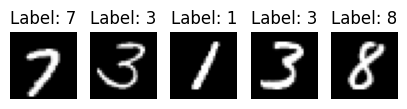

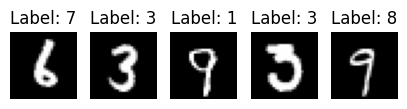

In [16]:
plot_images(train_dataset, 5)
plot_images(test_dataset, 5)

In [17]:
batch_size = 500


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

aux_loader = torch.utils.data.DataLoader(
    train_dataset, shuffle=True, batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [18]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 14 * 14, 10),
)

adam_model = copy.deepcopy(model)


scale_factor = 1
damping = 0.1
fishleg_model = initialise_FishModel(
    copy.deepcopy(model), module_names="__ALL__", fish_scale=scale_factor / damping
)

In [19]:
summary(adam_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
            Linear-5                   [-1, 10]          31,370
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


In [20]:
summary(fishleg_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        FishConv2d-1           [-1, 16, 28, 28]             416
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
           Flatten-4                 [-1, 3136]               0
        FishLinear-5                   [-1, 10]          31,370
Total params: 31,786
Trainable params: 31,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.12
Estimated Total Size (MB): 0.36
----------------------------------------------------------------


# Adam

In [21]:
likelihood = FISH_LIKELIHOODS["softmax"](device=device)

lr = 0.0005
# betas = (0.7, 0.9)
weight_decay = 1e-5
# eps = 1e-8

opt = optim.Adam(
    adam_model.parameters(),
    lr=lr,
    # betas=betas,
    weight_decay=weight_decay,
    # eps=eps,
)


adam_trained_model, adam_training_loss_per_step, adam_training_acc_per_step, adam_testing_loss_per_step, adam_testing_acc_per_step, adam_time_per_step = train_model(adam_model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=10, device=device)


  0%|          | 0/120 [00:00<?, ?batch/s]/home/xzcapwsl/GroupProject/FishLeg/examples/data_utils.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._images[idx]), torch.tensor(self._labels[idx])
Epoch 10: 100%|██████████| 120/120 [00:04<00:00, 26.08batch/s, acc=97.7, test_acc=97.8]


# FishLeg

In [22]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=16,
        kernel_size=5,
        stride=1,
        padding=2,
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(16 * 14 * 14, 10),
)

In [23]:
lr = 0.02
beta = 0.9
weight_decay = 1e-5

aux_lr = 1e-4
aux_eps = 1e-8
scale_factor = 1
damping = 0.1
update_aux_every = 3

initialization = "normal"
normalization = True

In [24]:
opt = FishLeg(
    fishleg_model,
    aux_loader,
    likelihood,
    lr=lr,
    beta=beta,
    weight_decay=weight_decay,
    aux_lr=aux_lr,
    aux_betas=(0.9, 0.999),
    aux_eps=aux_eps,
    damping=damping,
    update_aux_every=update_aux_every,
    # writer=writer,
    method="antithetic",
    method_kwargs={"eps": 1e-4},
    precondition_aux=True,
)
fishleg_trained_model, fishleg_training_loss_per_step, fishleg_training_acc_per_step, fishleg_testing_loss_per_step, fishlet_testing_acc_per_step, fishleg_time_per_step = train_model(fishleg_model, train_loader, test_loader, opt, likelihood, class_accuracy, epochs=10, device=device)

Epoch 10: 100%|██████████| 120/120 [00:08<00:00, 14.51batch/s, acc=98.1, test_acc=98.1]


Text(0, 0.5, 'Training Loss')

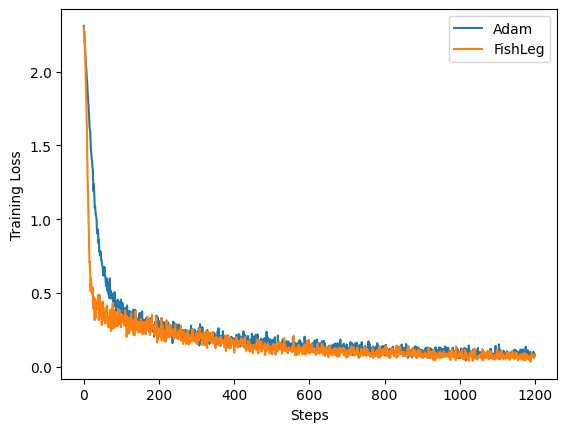

In [26]:
plt.plot(adam_training_loss_per_step, label="Adam")
plt.plot(fishleg_training_loss_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Accuracy')

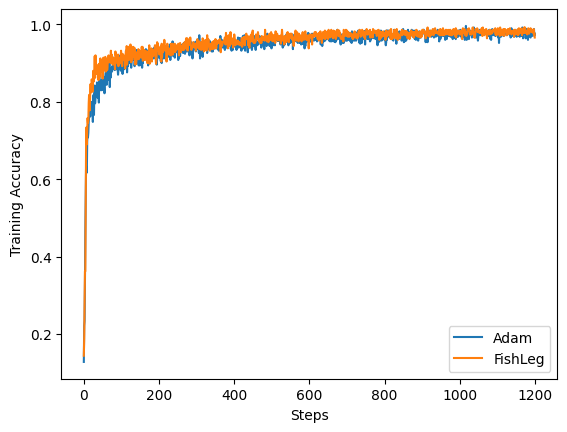

In [27]:
plt.plot(adam_training_acc_per_step, label="Adam")
plt.plot(fishleg_training_acc_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Steps")
plt.ylabel("Training Accuracy")

Text(0, 0.5, 'Training Loss')

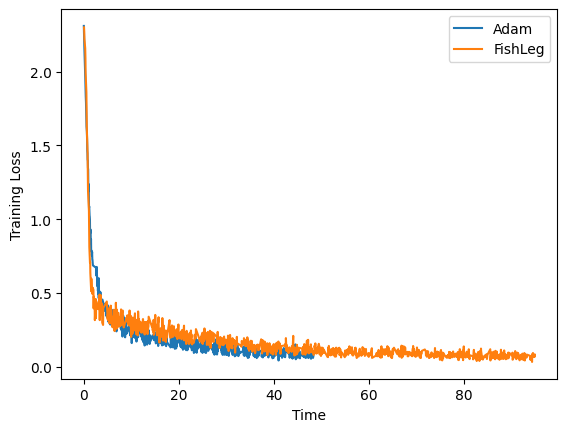

In [28]:
plt.plot(adam_time_per_step, adam_training_loss_per_step, label="Adam")
plt.plot(fishleg_time_per_step, fishleg_training_loss_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Loss")

Text(0, 0.5, 'Training Accuracy')

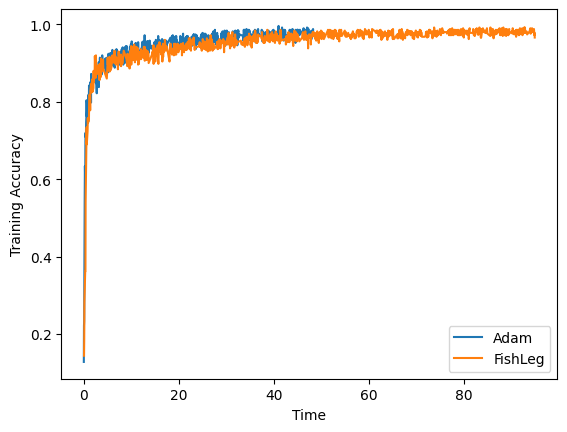

In [29]:
plt.plot(adam_time_per_step, adam_training_acc_per_step, label="Adam")
plt.plot(fishleg_time_per_step, fishleg_training_acc_per_step, label="FishLeg")
plt.legend(loc='best')
plt.xlabel("Time")
plt.ylabel("Training Accuracy")